# Supplement (bonus) to Specific Task (DeepLense): Exploring Transformers
### Chenguang Guan

1. In the task-1 notebook ("Deeplense_task1_classification.ipynb") and the first specific task notebook ("DeepLense_Specific_Task_Transformers.ipynb"), we have applied pre-trained ViT and Swin Transformer to the DeepLense classification problem.

2. In this notebook, we will compare ViT with MLP mixer, which is a supplement to the the first additional task notebook ("Deeplense_task1_classification.ipynb").

## I. Preparation

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!tar -xzvf /content/gdrive/MyDrive/lenses.tgz 

In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import glob
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms

import random
import time


from sklearn import metrics

import matplotlib.pyplot as plt

from PIL import Image

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## II. Dataset

In [ ]:
dataset_path = '/content/lenses'

In [ ]:
def dataset_path_list(dataset_dir):
    path_list = list()
    for dataset_class in ["no_sub", "sub"]:
        subdir = os.path.join(dataset_dir, dataset_class) + "/"
        path_list += list(glob.glob(subdir + "*.jpg") )
    return path_list

In [ ]:
def dataset_list(dataset_dir):
    data_list = list()
    for each_path in dataset_path_list(dataset_dir):
        data_list.append( np.expand_dims( np.array( Image.open( each_path ) ).astype(np.float32) / 255, axis=0 ) )
    return data_list

In [ ]:
X_list = dataset_list( dataset_path )
y_list = [0] * 5000 + [1] * 5000

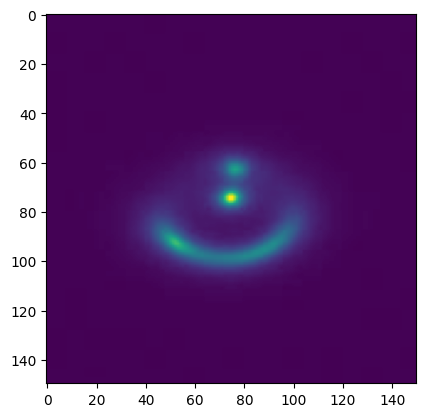

In [ ]:
plt.imshow(X_list[5000][0])
plt.show()

In [ ]:
X_list = np.array(X_list)
y_list = np.array(y_list)

In [ ]:
shuffle_list = np.arange(0, 10000, 1)
random.shuffle( shuffle_list )

In [ ]:
X_list = X_list[shuffle_list]
y_list = y_list[shuffle_list]

In [ ]:
X_list.shape

(10000, 1, 150, 150)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, train = True, transform = None, target_transform = None):
        global X_list, y_list
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.train:
            return 9000
        else:
            return 1000
    
    def __getitem__(self,idx):
        if self.train:
            image, label = torch.from_numpy( X_list[idx] ), y_list[idx]
        else:
            image, label = torch.from_numpy( X_list[idx+9000] ), y_list[idx+9000]
        
        if self.transform:
            image = self.transform( image )
        if self.target_transform:
            label = self.target_transform( label )

        return image, label 

### Data Augmentation

In [ ]:
my_transform_augmentation = transforms.RandomRotation(degrees=90)

In [ ]:
train_set = MyDataset(train=True)
train_loader =  DataLoader(train_set, batch_size=100, shuffle=True)

In [ ]:
train_set_not_aug = MyDataset(train=True)
train_loader_not_aug =  DataLoader(train_set_not_aug, batch_size=100, shuffle=False)

In [ ]:
test_set = MyDataset(train=False,)
test_loader =  DataLoader(test_set, batch_size=100, shuffle=False)

## III. Train and Test Loop

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 9
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

In [ ]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")
    
    return test_loss / num_batches

In [ ]:
def test_loop_prob(dataloader, model, class_i):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, class_i]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels==class_i).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## III. ViT

The implementation is from https://github.com/lucidrains/vit-pytorch, where we change the prenorm to postnorm.

Batch size: 500

Training on: A100 GPU

Learning Rate: if the test loss isn't improved for three consecutive epochs, the learning rate will be reduced by a factor of ten.

Optimizer: Adam

Test Accuracy: 50% (Pre-norm), 72.4% (Post-norm)

ROC-AUC score: 

1. The Pre-norm ViT learn nothing and is alomost a coin tosser.
2. However, the post-norm ViT can learn something, although the performance is worse than pre-trained ViT from pytorch libraries.

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.norm( self.fn(x, **kwargs) )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


### Pre-norm

In [ ]:
class Transformer_pre(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [ ]:
class ViT_pre(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer_pre(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

### Post-norm

In [25]:
class Transformer_post(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PostNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PostNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [26]:
class ViT_post(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer_post(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

### Training and Accuracy (ViT)

Pre-norm

In [ ]:
model_ViT = ViT_pre(image_size=150, patch_size=6, num_classes=2, dim=32, depth=6, heads=16, mlp_dim=128, pool="cls", channels=1, dim_head=16).to(device)

In [ ]:
lr = 1e-6
optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
lowest_loss = 1e4
count = 0
time_start = time.time()
for t in range( 20 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_ViT, criterion)
    if int(test_loss * 100) < lowest_loss:
        lowest_loss = int(test_loss * 100)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 1e-06
batch: [    9], loss: 0.821
temporary loss: 0.787494 | [  900/ 9000]
batch: [   18], loss: 0.848
temporary loss: 0.821138 | [ 1800/ 9000]
batch: [   27], loss: 0.810
temporary loss: 0.797683 | [ 2700/ 9000]
batch: [   36], loss: 0.812
temporary loss: 0.787200 | [ 3600/ 9000]
batch: [   45], loss: 0.810
temporary loss: 0.787695 | [ 4500/ 9000]
batch: [   54], loss: 0.818
temporary loss: 0.870380 | [ 5400/ 9000]
batch: [   63], loss: 0.796
temporary loss: 0.763347 | [ 6300/ 9000]
batch: [   72], loss: 0.784
temporary loss: 0.814376 | [ 7200/ 9000]
batch: [   81], loss: 0.782
temporary loss: 0.818362 | [ 8100/ 9000]
batch: [   90], loss: 0.819
temporary loss: 0.786538 | [ 9000/ 9000]
Test Error: 
 Accuracy: 50.0%
Avg loss: 0.789080 

-------------Epoch 2-------------
current learning rate 1e-06
batch: [    9], loss: 0.808
temporary loss: 0.829982 | [  900/ 9000]
batch: [   18], loss: 0.793
temporary loss: 0.726696 | [ 1800/ 900

Post-norm

In [27]:
model_ViT = ViT_post(image_size=150, patch_size=6, num_classes=2, dim=32, depth=6, heads=16, mlp_dim=128, pool="cls", channels=1, dim_head=16).to(device)

In [28]:
lr = 1e-5
optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
lowest_loss = 1e4
count = 0
time_start = time.time()
for t in range( 6 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_ViT, criterion)
    if int(test_loss * 100) < lowest_loss:
        lowest_loss = int(test_loss * 100)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 1e-05
batch: [    9], loss: 0.697
temporary loss: 0.694347 | [  900/ 9000]
batch: [   18], loss: 0.694
temporary loss: 0.691093 | [ 1800/ 9000]
batch: [   27], loss: 0.693
temporary loss: 0.689725 | [ 2700/ 9000]
batch: [   36], loss: 0.692
temporary loss: 0.704651 | [ 3600/ 9000]
batch: [   45], loss: 0.696
temporary loss: 0.687534 | [ 4500/ 9000]
batch: [   54], loss: 0.692
temporary loss: 0.701314 | [ 5400/ 9000]
batch: [   63], loss: 0.691
temporary loss: 0.687896 | [ 6300/ 9000]
batch: [   72], loss: 0.691
temporary loss: 0.693600 | [ 7200/ 9000]
batch: [   81], loss: 0.693
temporary loss: 0.689585 | [ 8100/ 9000]
batch: [   90], loss: 0.694
temporary loss: 0.698655 | [ 9000/ 9000]
Test Error: 
 Accuracy: 52.6%
Avg loss: 0.692148 

-------------Epoch 2-------------
current learning rate 1e-05
batch: [    9], loss: 0.692
temporary loss: 0.690657 | [  900/ 9000]
batch: [   18], loss: 0.691
temporary loss: 0.687481 | [ 1800/ 900

In [29]:
lr = 1e-5
lowest_loss = 1e4
count = 0
time_start = time.time()
for t in range( 20 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_ViT, criterion)
    if int(test_loss * 100) < lowest_loss:
        lowest_loss = int(test_loss * 100)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_ViT.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 1e-05
batch: [    9], loss: 0.669
temporary loss: 0.656839 | [  900/ 9000]
batch: [   18], loss: 0.672
temporary loss: 0.696362 | [ 1800/ 9000]
batch: [   27], loss: 0.677
temporary loss: 0.675114 | [ 2700/ 9000]
batch: [   36], loss: 0.669
temporary loss: 0.662364 | [ 3600/ 9000]
batch: [   45], loss: 0.665
temporary loss: 0.676390 | [ 4500/ 9000]
batch: [   54], loss: 0.670
temporary loss: 0.648163 | [ 5400/ 9000]
batch: [   63], loss: 0.663
temporary loss: 0.682883 | [ 6300/ 9000]
batch: [   72], loss: 0.668
temporary loss: 0.663478 | [ 7200/ 9000]
batch: [   81], loss: 0.661
temporary loss: 0.672832 | [ 8100/ 9000]
batch: [   90], loss: 0.658
temporary loss: 0.666985 | [ 9000/ 9000]
Test Error: 
 Accuracy: 62.1%
Avg loss: 0.665385 

-------------Epoch 2-------------
current learning rate 1e-05
batch: [    9], loss: 0.654
temporary loss: 0.637632 | [  900/ 9000]
batch: [   18], loss: 0.671
temporary loss: 0.659977 | [ 1800/ 900

## IV. MLP-mixer
The MLP-mixer architecture comes from https://arxiv.org/abs/2105.01601 . We implement this architecture.

Batch size: 200

Training on: A100 GPU

Learning Rate: if the test loss isn't improved for three consecutive epochs, the learning rate will be reduced by a factor of ten.

Optimizer: Adam

Test Accuracy: 91.4

ROC-AUC score: 0.972

MLP-mixer has a really good performance! And the computaional efficiency is really good.

In [31]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.norm( self.fn(x, **kwargs) )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [32]:
class MixerBlock(nn.Module):
    def __init__(self, patch_dim, MLP_dim1):
        super().__init__()

        self.MLP1 = nn.Sequential(
            nn.Linear(patch_dim, MLP_dim1),
            nn.GELU(),
            nn.Linear(MLP_dim1, patch_dim),
        )

    def forward(self, x):

        x = rearrange(x, "b n p -> b p n")
        x = self.MLP1(x)
        x = rearrange(x, "b p n -> b n p")

        return x

class MLPBlock(nn.Module):
    def __init__(self, dim, MLP_dim2):
        super().__init__()

        self.MLP2 = nn.Sequential(
            nn.Linear(dim, MLP_dim2),
            nn.GELU(),
            nn.Linear(MLP_dim2, dim),
        )

    def forward(self, x):

        x = self.MLP2(x)

        return x

In [33]:
class Transformer_post(nn.Module):
    def __init__(self, dim, patch_dim, depth, MLP_dim1, MLP_dim2):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PostNorm(dim, MixerBlock(patch_dim, MLP_dim1) ),
                PostNorm(dim, MLPBlock(dim, MLP_dim2) )
            ]))
    def forward(self, x):
        for mixer, ff in self.layers:
            x = mixer(x) + x
            x = ff(x) + x
        return x

In [34]:
class MLP_mixer_post(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, MLP_dim1, MLP_dim2, pool = 'cls', channels = 3):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = Transformer_post(dim, num_patches + 1, depth, MLP_dim1, MLP_dim2)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [41]:
model_mixer = MLP_mixer_post(image_size=150, patch_size=6, num_classes=2, dim=32, depth=6, MLP_dim1=128, MLP_dim2=1000, channels=1).to(device)

In [42]:
lr = 1e-4
optimizer = optim.Adam(model_mixer.parameters(), lr=lr)
lowest_loss = 1e6
count = 0
time_start = time.time()
for t in range( 25 ):
    print(f"-------------Epoch {t+1}-------------")
    print("current learning rate", lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    train_loop(train_loader, model_mixer, criterion, optimizer)
    test_loss = test_loop_Entropy(test_loader, model_mixer, criterion)
    if int(test_loss * 10000) < lowest_loss:
        lowest_loss = int(test_loss * 10000)
        count = 0
    else:
        count += 1
    if count == 3:
        lr /= 10
        optimizer = optim.Adam(model_mixer.parameters(), lr=lr)
        count = 0
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
current learning rate 0.0001
batch: [    9], loss: 0.709
temporary loss: 0.684861 | [  900/ 9000]
batch: [   18], loss: 0.686
temporary loss: 0.677836 | [ 1800/ 9000]
batch: [   27], loss: 0.681
temporary loss: 0.697925 | [ 2700/ 9000]
batch: [   36], loss: 0.669
temporary loss: 0.662154 | [ 3600/ 9000]
batch: [   45], loss: 0.659
temporary loss: 0.615148 | [ 4500/ 9000]
batch: [   54], loss: 0.626
temporary loss: 0.599907 | [ 5400/ 9000]
batch: [   63], loss: 0.570
temporary loss: 0.557729 | [ 6300/ 9000]
batch: [   72], loss: 0.528
temporary loss: 0.512480 | [ 7200/ 9000]
batch: [   81], loss: 0.483
temporary loss: 0.520097 | [ 8100/ 9000]
batch: [   90], loss: 0.485
temporary loss: 0.399080 | [ 9000/ 9000]
Test Error: 
 Accuracy: 74.0%
Avg loss: 0.466902 

-------------Epoch 2-------------
current learning rate 0.0001
batch: [    9], loss: 0.392
temporary loss: 0.334982 | [  900/ 9000]
batch: [   18], loss: 0.417
temporary loss: 0.444035 | [ 1800/ 9

In [47]:
path = "./gdrive/MyDrive/DeepLense_model/DeepLense_MLP_mixer_weights.pth"
torch.save(model_mixer.state_dict(), path)

### ROC-AUC (MLP-mixer, post-norm)

In [44]:
total_prob_mixer, total_label_mixer = test_loop_prob(test_loader, model_mixer, class_i=0)
fpr, tpr, thresholds = metrics.roc_curve(total_label_mixer, total_prob_mixer)
mixer_AUC_1 = metrics.roc_auc_score(total_label_mixer, total_prob_mixer)

Process: 0.0\%


In [45]:
print("The ROC-AUC score of MLP-mixer:", mixer_AUC_1)

The ROC-AUC score of MLP-mixer: 0.972552


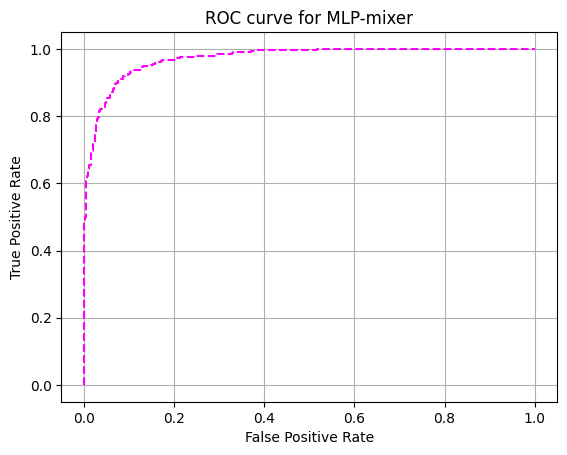

In [46]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for MLP-mixer")
plt.show()